In [1]:
# !pip install tqdm

In [1]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("mode.copy_on_write", True)

from tqdm.notebook import tqdm

In [2]:
scipy.__version__

'1.13.1'

In [3]:
class NASABatt:
    def __init__(self):
        self.steps_meta = None
        self.steps = None

    @property
    def as_time_series(self):
        return pd.concat([df.dropna(how='all', axis=1) for type, df in zip(self.steps_meta.type, self.steps) if
                          type in ('D', 'C', 'R')]).reset_index(drop=True).set_index('timestamp')


#np.concatenate(mat['data'][0,0]['step'][0, :]['voltage'], axis=1).shape
class NASABattRW(NASABatt):
    def __init__(self, f):
        super().__init__()
        self.mat = scipy.io.loadmat(f)['data'][0, 0]
        self.steps_meta = pd.DataFrame([
            np.concatenate((self.mat['step'][0, :]['date'])),
            np.concatenate((self.mat['step'][0, :]['comment'])),
            np.concatenate((self.mat['step'][0, :]['type'])),
        ]).T
        self.steps_meta.columns = ['start_time', 'comment', 'type']
        # self.steps = self.mat['step'][0]
        # self.steps_meta = pd.DataFrame([(s['comment'],
        #                                  s['type'],
        #                                  pd.to_datetime(s['date']),
        #                                  1 if type(s['time']) is not np.ndarray else len(s['time']),
        #                                  s['relativeTime'] if type(s['time']) is not np.ndarray else s['relativeTime'][-1]) for s in self.mat['step']],
        #                                columns=['comment', 'type', 'date', 'datapoints', 'stepTimeElapsed'])
        self.steps = [
            pd.DataFrame(np.stack(s[['time', 'relativeTime', 'voltage', 'current', 'temperature']]).T.reshape(-1, 5),
                         columns=['time', 'relativeTime', 'voltage', 'current', 'temperature']
                         ).rename({'relativeTime': 'step_time'}, axis=1).assign(
                charge_cc=lambda x: scipy.integrate.cumulative_trapezoid(x['current'], x['time'],
                                                                         initial=0) / 3600,
                timestamp=lambda x: pd.to_datetime(s['date'].item()) + pd.to_timedelta(x['step_time'], unit='s'))
            for s in tqdm(self.mat['step'][0])
        ]
        # self.steps = xr.concat(self.steps, dim='stepTime')


bRW = NASABattRW(
    "C:/Users/Worm/Downloads/1._Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post/Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post/data/Matlab/RW9.mat")

  0%|          | 0/113578 [00:00<?, ?it/s]

In [4]:
o = pd.concat([s.assign(step_type=m.comment, step=i) for s, (i, m) in zip(bRW.steps, bRW.steps_meta.iterrows())])

In [5]:
o.head() # seeing if the resulting df 'o' is what i expected

time  step_time  voltage  current  temperature  charge_cc  \
0   5.04       0.04    3.838   -2.007     24.38530   0.000000   
1  15.04      10.04    3.865   -2.000     24.38530  -0.005565   
2  25.04      20.04    3.878   -2.000     24.29163  -0.011121   
3  35.04      30.04    3.888   -2.000     24.24480  -0.016676   
4  45.04      40.04    3.895   -2.000     24.26041  -0.022232   

                timestamp         step_type  step  
0 2014-01-06 13:36:43.040  reference charge     0  
1 2014-01-06 13:36:53.040  reference charge     0  
2 2014-01-06 13:37:03.040  reference charge     0  
3 2014-01-06 13:37:13.040  reference charge     0  
4 2014-01-06 13:37:23.040  reference charge     0

In [6]:
o['step'].nunique() # increasing as should

113578

In [7]:
o['step'].tail()

716    113577
717    113577
718    113577
719    113577
720    113577
Name: step, dtype: int64

In [8]:
o['step_type'].value_counts() # note the different step types in this dataset

step_type
charge (random walk)                3869140
discharge (random walk)             3737664
pulsed load (rest)                   220982
reference charge                     148156
pulsed charge (rest)                 136911
rest (random walk)                   112683
pulsed load (discharge)              105325
pulsed charge (charge)                64353
rest post reference discharge         38934
reference discharge                   37400
low current discharge at 0.04A        28521
rest post pulsed load or charge       28106
rest post low current discharge        2162
rest post reference charge             1674
rest prior low current discharge         62
Name: count, dtype: int64

Everything looks good, but I need the instantaneous and reference capacities. 

### Instantaneous Capacity

In [9]:
# side note = include all rest when filtering for VR events
# one rest is weird / rest (random walk) one :(
# split up dataset by step "type" first will use 'comment' to acomplish this

In [10]:
# from above
bRW.steps_meta.head(10)
# there's ref. charge --> ref. discharge --> ref. charge --> ref. discharge --> pulsed load (rest) --> etc.

start_time                  comment type
0  06-Jan-2014 13:36:43         reference charge    C
1  06-Jan-2014 16:31:49      reference discharge    D
2  06-Jan-2014 18:37:42         reference charge    C
3  06-Jan-2014 21:32:56      reference discharge    D
4  07-Jan-2014 02:37:40       pulsed load (rest)    R
5  07-Jan-2014 02:57:41  pulsed load (discharge)    D
6  07-Jan-2014 03:07:41       pulsed load (rest)    R
7  07-Jan-2014 03:27:41  pulsed load (discharge)    D
8  07-Jan-2014 03:37:41       pulsed load (rest)    R
9  07-Jan-2014 03:57:41  pulsed load (discharge)    D

In [11]:
# checking this before we create 'good_ref' column because we don't trust the first step in ref types
steps_meta = bRW.steps_meta # assign it to a variable
steps_meta.comment.shift().str.contains('reference').head(10)

0     None
1     True
2     True
3     True
4     True
5    False
6    False
7    False
8    False
9    False
Name: comment, dtype: object

In [12]:
steps_meta.head(10) # okay, right

start_time                  comment type
0  06-Jan-2014 13:36:43         reference charge    C
1  06-Jan-2014 16:31:49      reference discharge    D
2  06-Jan-2014 18:37:42         reference charge    C
3  06-Jan-2014 21:32:56      reference discharge    D
4  07-Jan-2014 02:37:40       pulsed load (rest)    R
5  07-Jan-2014 02:57:41  pulsed load (discharge)    D
6  07-Jan-2014 03:07:41       pulsed load (rest)    R
7  07-Jan-2014 03:27:41  pulsed load (discharge)    D
8  07-Jan-2014 03:37:41       pulsed load (rest)    R
9  07-Jan-2014 03:57:41  pulsed load (discharge)    D

In [13]:
# pulses load and charge, refs, rw seperations
steps_meta['ref'] = steps_meta.comment.str.contains("reference") # keep in mind this gets replaced with 'good_ref' so drop later
steps_meta['pulsed_load'] = steps_meta.comment.str.contains("pulsed load")
steps_meta['pulsed_charge'] = steps_meta.comment.str.contains("pulsed charge")
steps_meta['rw'] = steps_meta.comment.str.contains("random")
steps_meta['good_ref'] = steps_meta.comment.shift().str.contains('reference') & steps_meta.ref & ~steps_meta.comment.str.contains('rest')

In [14]:
steps_meta.head() # as expected

start_time              comment type    ref  pulsed_load  \
0  06-Jan-2014 13:36:43     reference charge    C   True        False   
1  06-Jan-2014 16:31:49  reference discharge    D   True        False   
2  06-Jan-2014 18:37:42     reference charge    C   True        False   
3  06-Jan-2014 21:32:56  reference discharge    D   True        False   
4  07-Jan-2014 02:37:40   pulsed load (rest)    R  False         True   

   pulsed_charge     rw  good_ref  
0          False  False     False  
1          False  False      True  
2          False  False      True  
3          False  False      True  
4          False  False     False

In [15]:
# to aid in grouping steps together
steps_meta.iloc[:, -5:] # want these 

ref  pulsed_load  pulsed_charge     rw  good_ref
0        True        False          False  False     False
1        True        False          False  False      True
2        True        False          False  False      True
3        True        False          False  False      True
4       False         True          False  False     False
...       ...          ...            ...    ...       ...
113573   True        False          False  False     False
113574   True        False          False  False      True
113575   True        False          False  False     False
113576   True        False          False  False      True
113577   True        False          False  False     False

[113578 rows x 5 columns]

In [16]:
steps_meta.iloc[:, -5:].idxmax(axis = 1).tail(20) # see this makes sense 

113558     rw
113559     rw
113560     rw
113561     rw
113562     rw
113563     rw
113564     rw
113565     rw
113566     rw
113567     rw
113568     rw
113569     rw
113570    ref
113571    ref
113572    ref
113573    ref
113574    ref
113575    ref
113576    ref
113577    ref
dtype: object

In [17]:
steps_meta['group_type'] = steps_meta.iloc[:, -5:].idxmax(axis = 1)

In [18]:
steps_meta # good 

start_time                        comment type    ref  \
0       06-Jan-2014 13:36:43               reference charge    C   True   
1       06-Jan-2014 16:31:49            reference discharge    D   True   
2       06-Jan-2014 18:37:42               reference charge    C   True   
3       06-Jan-2014 21:32:56            reference discharge    D   True   
4       07-Jan-2014 02:37:40             pulsed load (rest)    R  False   
...                      ...                            ...  ...    ...   
113573  02-Jun-2014 02:04:29  rest post reference discharge    R   True   
113574  02-Jun-2014 04:04:30               reference charge    C   True   
113575  02-Jun-2014 09:46:42     rest post reference charge    R   True   
113576  02-Jun-2014 09:51:43            reference discharge    D   True   
113577  02-Jun-2014 10:36:45  rest post reference discharge    R   True   

        pulsed_load  pulsed_charge     rw  good_ref   group_type  
0             False          False  False     False          ref  
1             False          False  False      True          ref  
2             False          False  False      True          ref  
3             False          False  False      True          ref  
4              True          False  False     False  pulsed_load  
...             ...            ...    ...       ...          ...  
113573        False          False  False     False          ref  
113574        False          False  False      True          ref  
113575        False          False  False     False          ref  
113576        False          False  False      True          ref  
113577        False          False  False     False          ref  

[113578 rows x 9 columns]

In [19]:
# creating 'group' and detecting when the type changes in the list and numbers each group of the same type sequentially
steps_meta['group'] = (steps_meta['group_type'].shift() != steps_meta['group_type']).cumsum()

In [20]:
steps_meta

start_time                        comment type    ref  \
0       06-Jan-2014 13:36:43               reference charge    C   True   
1       06-Jan-2014 16:31:49            reference discharge    D   True   
2       06-Jan-2014 18:37:42               reference charge    C   True   
3       06-Jan-2014 21:32:56            reference discharge    D   True   
4       07-Jan-2014 02:37:40             pulsed load (rest)    R  False   
...                      ...                            ...  ...    ...   
113573  02-Jun-2014 02:04:29  rest post reference discharge    R   True   
113574  02-Jun-2014 04:04:30               reference charge    C   True   
113575  02-Jun-2014 09:46:42     rest post reference charge    R   True   
113576  02-Jun-2014 09:51:43            reference discharge    D   True   
113577  02-Jun-2014 10:36:45  rest post reference discharge    R   True   

        pulsed_load  pulsed_charge     rw  good_ref   group_type  group  
0             False          False  False     False          ref      1  
1             False          False  False      True          ref      1  
2             False          False  False      True          ref      1  
3             False          False  False      True          ref      1  
4              True          False  False     False  pulsed_load      2  
...             ...            ...    ...       ...          ...    ...  
113573        False          False  False     False          ref    130  
113574        False          False  False      True          ref    130  
113575        False          False  False     False          ref    130  
113576        False          False  False      True          ref    130  
113577        False          False  False     False          ref    130  

[113578 rows x 10 columns]

In [21]:
o.head() # to jog memory before merge of 'o' and 'steps_meta'

time  step_time  voltage  current  temperature  charge_cc  \
0   5.04       0.04    3.838   -2.007     24.38530   0.000000   
1  15.04      10.04    3.865   -2.000     24.38530  -0.005565   
2  25.04      20.04    3.878   -2.000     24.29163  -0.011121   
3  35.04      30.04    3.888   -2.000     24.24480  -0.016676   
4  45.04      40.04    3.895   -2.000     24.26041  -0.022232   

                timestamp         step_type  step  
0 2014-01-06 13:36:43.040  reference charge     0  
1 2014-01-06 13:36:53.040  reference charge     0  
2 2014-01-06 13:37:03.040  reference charge     0  
3 2014-01-06 13:37:13.040  reference charge     0  
4 2014-01-06 13:37:23.040  reference charge     0

In [22]:
o.merge(steps_meta, left_on = 'step', right_index = True) # merge

time  step_time  voltage  current  temperature  charge_cc  \
0           5.04       0.04    3.838   -2.007     24.38530   0.000000   
1          15.04      10.04    3.865   -2.000     24.38530  -0.005565   
2          25.04      20.04    3.878   -2.000     24.29163  -0.011121   
3          35.04      30.04    3.888   -2.000     24.24480  -0.016676   
4          45.04      40.04    3.895   -2.000     24.26041  -0.022232   
..           ...        ...      ...      ...          ...        ...   
716  12713339.64    7160.01    3.801    0.000     33.31358   0.000000   
717  12713349.64    7170.01    3.801    0.000     33.31358   0.000000   
718  12713359.64    7180.01    3.801    0.000     33.29812   0.000000   
719  12713369.64    7190.01    3.801    0.000     33.29812   0.000000   
720  12713379.63    7200.00    3.801    0.000     33.29812   0.000000   

                  timestamp                      step_type    step  \
0   2014-01-06 13:36:43.040               reference charge       0   
1   2014-01-06 13:36:53.040               reference charge       0   
2   2014-01-06 13:37:03.040               reference charge       0   
3   2014-01-06 13:37:13.040               reference charge       0   
4   2014-01-06 13:37:23.040               reference charge       0   
..                      ...                            ...     ...   
716 2014-06-02 12:36:05.010  rest post reference discharge  113577   
717 2014-06-02 12:36:15.010  rest post reference discharge  113577   
718 2014-06-02 12:36:25.010  rest post reference discharge  113577   
719 2014-06-02 12:36:35.010  rest post reference discharge  113577   
720 2014-06-02 12:36:45.000  rest post reference discharge  113577   

               start_time                        comment type   ref  \
0    06-Jan-2014 13:36:43               reference charge    C  True   
1    06-Jan-2014 13:36:43               reference charge    C  True   
2    06-Jan-2014 13:36:43               reference charge    C  True   
3    06-Jan-2014 13:36:43               reference charge    C  True   
4    06-Jan-2014 13:36:43               reference charge    C  True   
..                    ...                            ...  ...   ...   
716  02-Jun-2014 10:36:45  rest post reference discharge    R  True   
717  02-Jun-2014 10:36:45  rest post reference discharge    R  True   
718  02-Jun-2014 10:36:45  rest post reference discharge    R  True   
719  02-Jun-2014 10:36:45  rest post reference discharge    R  True   
720  02-Jun-2014 10:36:45  rest post reference discharge    R  True   

     pulsed_load  pulsed_charge     rw  good_ref group_type  group  
0          False          False  False     False        ref      1  
1          False          False  False     False        ref      1  
2          False          False  False     False        ref      1  
3          False          False  False     False        ref      1  
4          False          False  False     False        ref      1  
..           ...            ...    ...       ...        ...    ...  
716        False          False  False     False        ref    130  
717        False          False  False     False        ref    130  
718        False          False  False     False        ref    130  
719        False          False  False     False        ref    130  
720        False          False  False     False        ref    130  

[8532073 rows x 19 columns]

In [23]:
o = _22

In [24]:
o['capacity'] = None # run this in case / it took me a few tries to get this right so need this column empty 
for (i, data) in o.groupby('group'): 
  o.loc[o.group == i, 'capacity' ] = scipy.integrate.cumulative_trapezoid(data['current'], data['time'], initial=0) / 3600

In [25]:
o

time  step_time  voltage  current  temperature  charge_cc  \
0           5.04       0.04    3.838   -2.007     24.38530   0.000000   
1          15.04      10.04    3.865   -2.000     24.38530  -0.005565   
2          25.04      20.04    3.878   -2.000     24.29163  -0.011121   
3          35.04      30.04    3.888   -2.000     24.24480  -0.016676   
4          45.04      40.04    3.895   -2.000     24.26041  -0.022232   
..           ...        ...      ...      ...          ...        ...   
716  12713339.64    7160.01    3.801    0.000     33.31358   0.000000   
717  12713349.64    7170.01    3.801    0.000     33.31358   0.000000   
718  12713359.64    7180.01    3.801    0.000     33.29812   0.000000   
719  12713369.64    7190.01    3.801    0.000     33.29812   0.000000   
720  12713379.63    7200.00    3.801    0.000     33.29812   0.000000   

                  timestamp                      step_type    step  \
0   2014-01-06 13:36:43.040               reference charge       0   
1   2014-01-06 13:36:53.040               reference charge       0   
2   2014-01-06 13:37:03.040               reference charge       0   
3   2014-01-06 13:37:13.040               reference charge       0   
4   2014-01-06 13:37:23.040               reference charge       0   
..                      ...                            ...     ...   
716 2014-06-02 12:36:05.010  rest post reference discharge  113577   
717 2014-06-02 12:36:15.010  rest post reference discharge  113577   
718 2014-06-02 12:36:25.010  rest post reference discharge  113577   
719 2014-06-02 12:36:35.010  rest post reference discharge  113577   
720 2014-06-02 12:36:45.000  rest post reference discharge  113577   

               start_time                        comment type   ref  \
0    06-Jan-2014 13:36:43               reference charge    C  True   
1    06-Jan-2014 13:36:43               reference charge    C  True   
2    06-Jan-2014 13:36:43               reference charge    C  True   
3    06-Jan-2014 13:36:43               reference charge    C  True   
4    06-Jan-2014 13:36:43               reference charge    C  True   
..                    ...                            ...  ...   ...   
716  02-Jun-2014 10:36:45  rest post reference discharge    R  True   
717  02-Jun-2014 10:36:45  rest post reference discharge    R  True   
718  02-Jun-2014 10:36:45  rest post reference discharge    R  True   
719  02-Jun-2014 10:36:45  rest post reference discharge    R  True   
720  02-Jun-2014 10:36:45  rest post reference discharge    R  True   

     pulsed_load  pulsed_charge     rw  good_ref group_type  group  capacity  
0          False          False  False     False        ref      1       0.0  
1          False          False  False     False        ref      1 -0.005565  
2          False          False  False     False        ref      1 -0.011121  
3          False          False  False     False        ref      1 -0.016676  
4          False          False  False     False        ref      1 -0.022232  
..           ...            ...    ...       ...        ...    ...       ...  
716        False          False  False     False        ref    130  -0.34894  
717        False          False  False     False        ref    130  -0.34894  
718        False          False  False     False        ref    130  -0.34894  
719        False          False  False     False        ref    130  -0.34894  
720        False          False  False     False        ref    130  -0.34894  

[8532073 rows x 20 columns]

In [76]:
o['capacity'][o['group'] == 4].head() # it's in amp hours

0         0.0
1   -0.005554
2   -0.011111
3   -0.016667
4   -0.022222
Name: capacity, dtype: object

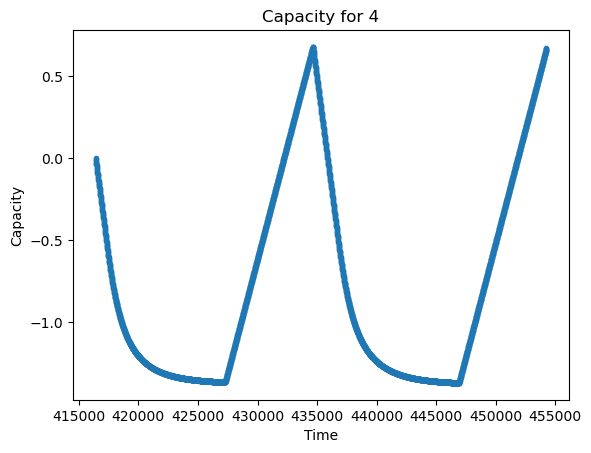

In [77]:
# filter for group  = 4 and sort by time
# i had issues plotting if i didn't filter by time?
group4 = o[o['group'] == 4].sort_values('time')

plt.plot(group4['time'], group4['capacity'], marker='.')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.title('Capacity for 4')
plt.show()

In [78]:
abs(o['capacity']).head(10)

0         0.0
1    0.005565
2    0.011121
3    0.016676
4    0.022232
5    0.027787
6    0.033343
7    0.038899
8    0.044454
9     0.05001
Name: capacity, dtype: object

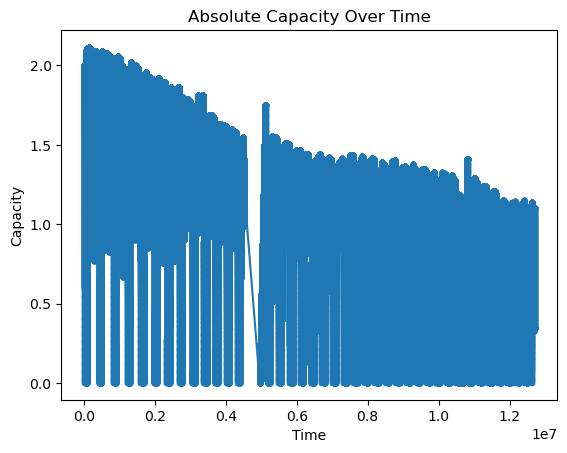

In [79]:
o.sort_values('time').set_index('time')['capacity'].abs().plot(marker='.')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.title('Absolute Capacity Over Time')
plt.show() # this looks right to me
# the units may need to be adjusted 
# rw2 shows this graph with capacity in the thousands
# i think the difference is that we have 'good_ref' now, but the trends appear to be the same 

### Reference Capacity

In [30]:
# from good_ref charging steps only 
# no upper and lower bounding as was done before with full-discharge dataset

In [31]:
# ref. capacity = last instance of capacity at any good_ref step  

In [80]:
o.columns

Index(['time', 'step_time', 'voltage', 'current', 'temperature', 'charge_cc',
       'timestamp', 'step_type', 'step', 'start_time', 'comment', 'type',
       'ref', 'pulsed_load', 'pulsed_charge', 'rw', 'good_ref', 'group_type',
       'group', 'capacity'],
      dtype='object')

In [81]:
o['good_ref'].value_counts()

good_ref
False    8426692
True      105381
Name: count, dtype: int64

In [82]:
o[o.good_ref == True]

time  step_time  voltage  current  temperature  charge_cc  \
0       10509.70       0.04    4.113    1.004     22.10602   0.000000   
1       10519.70      10.04    4.099    1.000     22.05919   0.002783   
2       10529.70      20.04    4.091    1.000     22.04357   0.005561   
3       10539.70      30.04    4.085    1.000     22.01235   0.008339   
4       10549.70      40.04    4.079    1.000     21.98113   0.011117   
..           ...        ...      ...      ...          ...        ...   
267  12706148.83    2670.04    3.215    1.000     38.78600   0.741629   
268  12706158.83    2680.04    3.210    1.000     38.80146   0.744407   
269  12706168.83    2690.04    3.205    1.000     38.83238   0.747185   
270  12706178.83    2700.04    3.200    1.000     38.86329   0.749962   
271  12706179.63    2700.84    3.200    1.000     38.86329   0.750185   

                  timestamp            step_type    step  \
0   2014-01-06 16:31:49.040  reference discharge       1   
1   2014-01-06 16:31:59.040  reference discharge       1   
2   2014-01-06 16:32:09.040  reference discharge       1   
3   2014-01-06 16:32:19.040  reference discharge       1   
4   2014-01-06 16:32:29.040  reference discharge       1   
..                      ...                  ...     ...   
267 2014-06-02 10:36:13.040  reference discharge  113576   
268 2014-06-02 10:36:23.040  reference discharge  113576   
269 2014-06-02 10:36:33.040  reference discharge  113576   
270 2014-06-02 10:36:43.040  reference discharge  113576   
271 2014-06-02 10:36:43.840  reference discharge  113576   

               start_time              comment type   ref  pulsed_load  \
0    06-Jan-2014 16:31:49  reference discharge    D  True        False   
1    06-Jan-2014 16:31:49  reference discharge    D  True        False   
2    06-Jan-2014 16:31:49  reference discharge    D  True        False   
3    06-Jan-2014 16:31:49  reference discharge    D  True        False   
4    06-Jan-2014 16:31:49  reference discharge    D  True        False   
..                    ...                  ...  ...   ...          ...   
267  02-Jun-2014 09:51:43  reference discharge    D  True        False   
268  02-Jun-2014 09:51:43  reference discharge    D  True        False   
269  02-Jun-2014 09:51:43  reference discharge    D  True        False   
270  02-Jun-2014 09:51:43  reference discharge    D  True        False   
271  02-Jun-2014 09:51:43  reference discharge    D  True        False   

     pulsed_charge     rw  good_ref group_type  group  capacity  
0            False  False      True        ref      1 -2.002084  
1            False  False      True        ref      1 -1.999301  
2            False  False      True        ref      1 -1.996523  
3            False  False      True        ref      1 -1.993745  
4            False  False      True        ref      1 -1.990968  
..             ...    ...       ...        ...    ...       ...  
267          False  False      True        ref    130 -0.357497  
268          False  False      True        ref    130 -0.354719  
269          False  False      True        ref    130 -0.351942  
270          False  False      True        ref    130 -0.349164  
271          False  False      True        ref    130 -0.348942  

[105381 rows x 20 columns]

In [147]:
# filter o for only rows where 'good_ref' = True
test = o[o['good_ref'] == True] # checking this before assigning variable i need
test.head()
# you can see there are instances where both 'good_ref' and 'ref' are true

time  step_time  voltage  current  temperature  charge_cc  \
0  10509.7       0.04    4.113    1.004     22.10602   0.000000   
1  10519.7      10.04    4.099    1.000     22.05919   0.002783   
2  10529.7      20.04    4.091    1.000     22.04357   0.005561   
3  10539.7      30.04    4.085    1.000     22.01235   0.008339   
4  10549.7      40.04    4.079    1.000     21.98113   0.011117   

                timestamp            step_type  step            start_time  \
0 2014-01-06 16:31:49.040  reference discharge     1  06-Jan-2014 16:31:49   
1 2014-01-06 16:31:59.040  reference discharge     1  06-Jan-2014 16:31:49   
2 2014-01-06 16:32:09.040  reference discharge     1  06-Jan-2014 16:31:49   
3 2014-01-06 16:32:19.040  reference discharge     1  06-Jan-2014 16:31:49   
4 2014-01-06 16:32:29.040  reference discharge     1  06-Jan-2014 16:31:49   

               comment type   ref  pulsed_load  pulsed_charge     rw  \
0  reference discharge    D  True        False          False  False   
1  reference discharge    D  True        False          False  False   
2  reference discharge    D  True        False          False  False   
3  reference discharge    D  True        False          False  False   
4  reference discharge    D  True        False          False  False   

   good_ref group_type  group  capacity  
0      True        ref      1 -2.002084  
1      True        ref      1 -1.999301  
2      True        ref      1 -1.996523  
3      True        ref      1 -1.993745  
4      True        ref      1 -1.990968

In [36]:
# i tried dropping 'ref' first but i don't think that makes sense or matters
# because 'good_ref' is still true and filtering doesn't consider cases where it is false
# ---------
# drop 'ref' from o
# then filter for only 'good_ref'
# o.drop('ref', axis = 1, inplace = True)
# o.columns

In [84]:
o['comment'].unique()

array(['reference charge', 'reference discharge', 'pulsed load (rest)',
       'pulsed load (discharge)', 'rest (random walk)',
       'discharge (random walk)', 'charge (random walk)',
       'pulsed charge (rest)', 'pulsed charge (charge)',
       'rest prior low current discharge',
       'low current discharge at 0.04A',
       'rest post low current discharge', 'rest post reference charge',
       'rest post reference discharge', 'rest post pulsed load or charge'],
      dtype=object)

In [148]:
another_test = o[(o.good_ref == True) & ~(o.comment.str.contains('rest'))]

In [149]:
another_test

time  step_time  voltage  current  temperature  charge_cc  \
0       10509.70       0.04    4.113    1.004     22.10602   0.000000   
1       10519.70      10.04    4.099    1.000     22.05919   0.002783   
2       10529.70      20.04    4.091    1.000     22.04357   0.005561   
3       10539.70      30.04    4.085    1.000     22.01235   0.008339   
4       10549.70      40.04    4.079    1.000     21.98113   0.011117   
..           ...        ...      ...      ...          ...        ...   
267  12706148.83    2670.04    3.215    1.000     38.78600   0.741629   
268  12706158.83    2680.04    3.210    1.000     38.80146   0.744407   
269  12706168.83    2690.04    3.205    1.000     38.83238   0.747185   
270  12706178.83    2700.04    3.200    1.000     38.86329   0.749962   
271  12706179.63    2700.84    3.200    1.000     38.86329   0.750185   

                  timestamp            step_type    step  \
0   2014-01-06 16:31:49.040  reference discharge       1   
1   2014-01-06 16:31:59.040  reference discharge       1   
2   2014-01-06 16:32:09.040  reference discharge       1   
3   2014-01-06 16:32:19.040  reference discharge       1   
4   2014-01-06 16:32:29.040  reference discharge       1   
..                      ...                  ...     ...   
267 2014-06-02 10:36:13.040  reference discharge  113576   
268 2014-06-02 10:36:23.040  reference discharge  113576   
269 2014-06-02 10:36:33.040  reference discharge  113576   
270 2014-06-02 10:36:43.040  reference discharge  113576   
271 2014-06-02 10:36:43.840  reference discharge  113576   

               start_time              comment type   ref  pulsed_load  \
0    06-Jan-2014 16:31:49  reference discharge    D  True        False   
1    06-Jan-2014 16:31:49  reference discharge    D  True        False   
2    06-Jan-2014 16:31:49  reference discharge    D  True        False   
3    06-Jan-2014 16:31:49  reference discharge    D  True        False   
4    06-Jan-2014 16:31:49  reference discharge    D  True        False   
..                    ...                  ...  ...   ...          ...   
267  02-Jun-2014 09:51:43  reference discharge    D  True        False   
268  02-Jun-2014 09:51:43  reference discharge    D  True        False   
269  02-Jun-2014 09:51:43  reference discharge    D  True        False   
270  02-Jun-2014 09:51:43  reference discharge    D  True        False   
271  02-Jun-2014 09:51:43  reference discharge    D  True        False   

     pulsed_charge     rw  good_ref group_type  group  capacity  
0            False  False      True        ref      1 -2.002084  
1            False  False      True        ref      1 -1.999301  
2            False  False      True        ref      1 -1.996523  
3            False  False      True        ref      1 -1.993745  
4            False  False      True        ref      1 -1.990968  
..             ...    ...       ...        ...    ...       ...  
267          False  False      True        ref    130 -0.357497  
268          False  False      True        ref    130 -0.354719  
269          False  False      True        ref    130 -0.351942  
270          False  False      True        ref    130 -0.349164  
271          False  False      True        ref    130 -0.348942  

[105381 rows x 20 columns]

In [87]:
another_test['comment'].unique()

array(['reference discharge', 'reference charge'], dtype=object)

In [88]:
another_test['step_type'].unique() # the filtering works

array(['reference discharge', 'reference charge'], dtype=object)

In [231]:
refs = o[(o.good_ref == True) & ~(o.comment.str.contains('rest'))] # run and assign to variable

In [232]:
refs

time  step_time  voltage  current  temperature  charge_cc  \
0       10509.70       0.04    4.113    1.004     22.10602   0.000000   
1       10519.70      10.04    4.099    1.000     22.05919   0.002783   
2       10529.70      20.04    4.091    1.000     22.04357   0.005561   
3       10539.70      30.04    4.085    1.000     22.01235   0.008339   
4       10549.70      40.04    4.079    1.000     21.98113   0.011117   
..           ...        ...      ...      ...          ...        ...   
267  12706148.83    2670.04    3.215    1.000     38.78600   0.741629   
268  12706158.83    2680.04    3.210    1.000     38.80146   0.744407   
269  12706168.83    2690.04    3.205    1.000     38.83238   0.747185   
270  12706178.83    2700.04    3.200    1.000     38.86329   0.749962   
271  12706179.63    2700.84    3.200    1.000     38.86329   0.750185   

                  timestamp            step_type    step  \
0   2014-01-06 16:31:49.040  reference discharge       1   
1   2014-01-06 16:31:59.040  reference discharge       1   
2   2014-01-06 16:32:09.040  reference discharge       1   
3   2014-01-06 16:32:19.040  reference discharge       1   
4   2014-01-06 16:32:29.040  reference discharge       1   
..                      ...                  ...     ...   
267 2014-06-02 10:36:13.040  reference discharge  113576   
268 2014-06-02 10:36:23.040  reference discharge  113576   
269 2014-06-02 10:36:33.040  reference discharge  113576   
270 2014-06-02 10:36:43.040  reference discharge  113576   
271 2014-06-02 10:36:43.840  reference discharge  113576   

               start_time              comment type   ref  pulsed_load  \
0    06-Jan-2014 16:31:49  reference discharge    D  True        False   
1    06-Jan-2014 16:31:49  reference discharge    D  True        False   
2    06-Jan-2014 16:31:49  reference discharge    D  True        False   
3    06-Jan-2014 16:31:49  reference discharge    D  True        False   
4    06-Jan-2014 16:31:49  reference discharge    D  True        False   
..                    ...                  ...  ...   ...          ...   
267  02-Jun-2014 09:51:43  reference discharge    D  True        False   
268  02-Jun-2014 09:51:43  reference discharge    D  True        False   
269  02-Jun-2014 09:51:43  reference discharge    D  True        False   
270  02-Jun-2014 09:51:43  reference discharge    D  True        False   
271  02-Jun-2014 09:51:43  reference discharge    D  True        False   

     pulsed_charge     rw  good_ref group_type  group  capacity  
0            False  False      True        ref      1 -2.002084  
1            False  False      True        ref      1 -1.999301  
2            False  False      True        ref      1 -1.996523  
3            False  False      True        ref      1 -1.993745  
4            False  False      True        ref      1 -1.990968  
..             ...    ...       ...        ...    ...       ...  
267          False  False      True        ref    130 -0.357497  
268          False  False      True        ref    130 -0.354719  
269          False  False      True        ref    130 -0.351942  
270          False  False      True        ref    130 -0.349164  
271          False  False      True        ref    130 -0.348942  

[105381 rows x 20 columns]

In [233]:
ref_capacity = refs.groupby('step').apply(lambda df:scipy.integrate.trapezoid(df.current, df.time)) # join back to other later

C:\Users\Worm\AppData\Local\Temp\ipykernel_17796\1884718042.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ref_capacity = refs.groupby('step').apply(lambda df:scipy.integrate.trapezoid(df.current, df.time)) # join back to other later


In [234]:
ref_capacity

step
1         7551.860000
2        -7557.865825
3         7540.795000
3031      7360.440710
3032     -7375.177925
             ...     
110553   -2822.363480
110555    2731.404115
113572    2695.545000
113574   -2781.995705
113576    2700.665000
Length: 120, dtype: float64

<Axes: xlabel='step'>

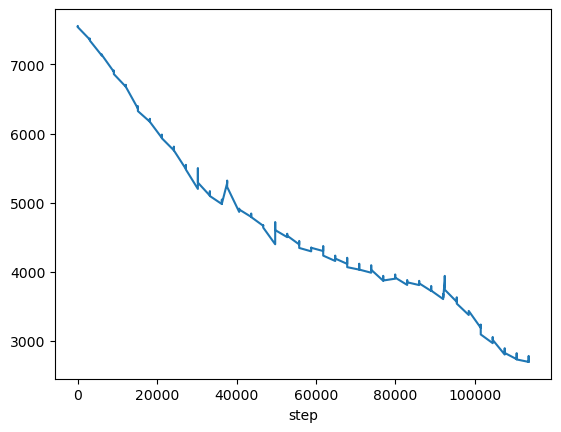

In [235]:
ref_capacity.abs().plot()

In [236]:
# convert ref_capacity series to df
ref_capacity_df = ref_capacity.to_frame('ref_capacity')

# merge df with 'o' using 'step' from o and the index of ref_capacity_df
o = o.merge(ref_capacity_df, left_on='step', right_index=True, how='left')

In [237]:
o

time  step_time  voltage  current  temperature  charge_cc  \
0           5.04       0.04    3.838   -2.007     24.38530   0.000000   
1          15.04      10.04    3.865   -2.000     24.38530  -0.005565   
2          25.04      20.04    3.878   -2.000     24.29163  -0.011121   
3          35.04      30.04    3.888   -2.000     24.24480  -0.016676   
4          45.04      40.04    3.895   -2.000     24.26041  -0.022232   
..           ...        ...      ...      ...          ...        ...   
716  12713339.64    7160.01    3.801    0.000     33.31358   0.000000   
717  12713349.64    7170.01    3.801    0.000     33.31358   0.000000   
718  12713359.64    7180.01    3.801    0.000     33.29812   0.000000   
719  12713369.64    7190.01    3.801    0.000     33.29812   0.000000   
720  12713379.63    7200.00    3.801    0.000     33.29812   0.000000   

                  timestamp                      step_type    step  \
0   2014-01-06 13:36:43.040               reference charge       0   
1   2014-01-06 13:36:53.040               reference charge       0   
2   2014-01-06 13:37:03.040               reference charge       0   
3   2014-01-06 13:37:13.040               reference charge       0   
4   2014-01-06 13:37:23.040               reference charge       0   
..                      ...                            ...     ...   
716 2014-06-02 12:36:05.010  rest post reference discharge  113577   
717 2014-06-02 12:36:15.010  rest post reference discharge  113577   
718 2014-06-02 12:36:25.010  rest post reference discharge  113577   
719 2014-06-02 12:36:35.010  rest post reference discharge  113577   
720 2014-06-02 12:36:45.000  rest post reference discharge  113577   

               start_time  ... type   ref  pulsed_load  pulsed_charge     rw  \
0    06-Jan-2014 13:36:43  ...    C  True        False          False  False   
1    06-Jan-2014 13:36:43  ...    C  True        False          False  False   
2    06-Jan-2014 13:36:43  ...    C  True        False          False  False   
3    06-Jan-2014 13:36:43  ...    C  True        False          False  False   
4    06-Jan-2014 13:36:43  ...    C  True        False          False  False   
..                    ...  ...  ...   ...          ...            ...    ...   
716  02-Jun-2014 10:36:45  ...    R  True        False          False  False   
717  02-Jun-2014 10:36:45  ...    R  True        False          False  False   
718  02-Jun-2014 10:36:45  ...    R  True        False          False  False   
719  02-Jun-2014 10:36:45  ...    R  True        False          False  False   
720  02-Jun-2014 10:36:45  ...    R  True        False          False  False   

     good_ref  group_type group  capacity ref_capacity  
0       False         ref     1       0.0          NaN  
1       False         ref     1 -0.005565          NaN  
2       False         ref     1 -0.011121          NaN  
3       False         ref     1 -0.016676          NaN  
4       False         ref     1 -0.022232          NaN  
..        ...         ...   ...       ...          ...  
716     False         ref   130  -0.34894          NaN  
717     False         ref   130  -0.34894          NaN  
718     False         ref   130  -0.34894          NaN  
719     False         ref   130  -0.34894          NaN  
720     False         ref   130  -0.34894          NaN  

[8532073 rows x 21 columns]

In [238]:
o['ref_capacity'] = o['ref_capacity'].abs()
# this is needed for the next step since we are taking the mean of each group --> need it to be positive or it messes up

In [241]:
o['group_ref'] = o.groupby('group')['ref_capacity'].transform('mean')

In [242]:
o # this worked but now must linearly interpolate for the groups with missing refs

time  step_time  voltage  current  temperature  charge_cc  \
0           5.04       0.04    3.838   -2.007     24.38530   0.000000   
1          15.04      10.04    3.865   -2.000     24.38530  -0.005565   
2          25.04      20.04    3.878   -2.000     24.29163  -0.011121   
3          35.04      30.04    3.888   -2.000     24.24480  -0.016676   
4          45.04      40.04    3.895   -2.000     24.26041  -0.022232   
..           ...        ...      ...      ...          ...        ...   
716  12713339.64    7160.01    3.801    0.000     33.31358   0.000000   
717  12713349.64    7170.01    3.801    0.000     33.31358   0.000000   
718  12713359.64    7180.01    3.801    0.000     33.29812   0.000000   
719  12713369.64    7190.01    3.801    0.000     33.29812   0.000000   
720  12713379.63    7200.00    3.801    0.000     33.29812   0.000000   

                  timestamp                      step_type    step  \
0   2014-01-06 13:36:43.040               reference charge       0   
1   2014-01-06 13:36:53.040               reference charge       0   
2   2014-01-06 13:37:03.040               reference charge       0   
3   2014-01-06 13:37:13.040               reference charge       0   
4   2014-01-06 13:37:23.040               reference charge       0   
..                      ...                            ...     ...   
716 2014-06-02 12:36:05.010  rest post reference discharge  113577   
717 2014-06-02 12:36:15.010  rest post reference discharge  113577   
718 2014-06-02 12:36:25.010  rest post reference discharge  113577   
719 2014-06-02 12:36:35.010  rest post reference discharge  113577   
720 2014-06-02 12:36:45.000  rest post reference discharge  113577   

               start_time  ...   ref pulsed_load  pulsed_charge     rw  \
0    06-Jan-2014 13:36:43  ...  True       False          False  False   
1    06-Jan-2014 13:36:43  ...  True       False          False  False   
2    06-Jan-2014 13:36:43  ...  True       False          False  False   
3    06-Jan-2014 13:36:43  ...  True       False          False  False   
4    06-Jan-2014 13:36:43  ...  True       False          False  False   
..                    ...  ...   ...         ...            ...    ...   
716  02-Jun-2014 10:36:45  ...  True       False          False  False   
717  02-Jun-2014 10:36:45  ...  True       False          False  False   
718  02-Jun-2014 10:36:45  ...  True       False          False  False   
719  02-Jun-2014 10:36:45  ...  True       False          False  False   
720  02-Jun-2014 10:36:45  ...  True       False          False  False   

     good_ref  group_type  group  capacity  ref_capacity    group_ref  
0       False         ref      1       0.0           NaN  7551.064596  
1       False         ref      1 -0.005565           NaN  7551.064596  
2       False         ref      1 -0.011121           NaN  7551.064596  
3       False         ref      1 -0.016676           NaN  7551.064596  
4       False         ref      1 -0.022232           NaN  7551.064596  
..        ...         ...    ...       ...           ...          ...  
716     False         ref    130  -0.34894           NaN  2764.462952  
717     False         ref    130  -0.34894           NaN  2764.462952  
718     False         ref    130  -0.34894           NaN  2764.462952  
719     False         ref    130  -0.34894           NaN  2764.462952  
720     False         ref    130  -0.34894           NaN  2764.462952  

[8532073 rows x 22 columns]

In [163]:
o.groupby('group').ref_capacity.mean() # used this to compare 'o' result above

group
1      7551.064596
2              NaN
3              NaN
4      7363.489344
5              NaN
          ...     
126            NaN
127    2802.995480
128            NaN
129            NaN
130    2764.462952
Name: ref_capacity, Length: 130, dtype: float64

In [246]:
# linear interp. for missing 'group_ref' values
# each group's first value
group_means = o.groupby('group')['group_ref'].first()

In [249]:
# sort and interpolate 
group_means = group_means.sort_index()
group_means_interp = group_means.interpolate(method='linear')

In [251]:
# map back to 'o'
o['group_ref_interp'] = o['group'].map(group_means_interp)

In [270]:
group_means.interpolate(method='linear') # compare these interp. values with those in each group for 'o'

group
1      7551.064596
2      7488.539512
3      7426.014428
4      7363.489344
5      7288.714840
          ...     
126    2821.269593
127    2802.995480
128    2790.151304
129    2777.307128
130    2764.462952
Name: group_ref, Length: 130, dtype: float64

In [269]:
o[o['group'] ==2].tail() # checked and it worked

time  step_time  voltage  current  temperature  charge_cc  \
343  70001.11     343.04    3.208    1.000     24.74436   0.095270   
344  70002.11     344.04    3.206    1.001     24.74436   0.095548   
345  70003.11     345.04    3.204    1.000     24.74436   0.095826   
346  70004.11     346.04    3.202    1.000     24.75998   0.096104   
347  70004.75     346.68    3.200    1.000     24.75998   0.096281   

                  timestamp                step_type  step  \
343 2014-01-07 09:03:24.040  pulsed load (discharge)    29   
344 2014-01-07 09:03:25.040  pulsed load (discharge)    29   
345 2014-01-07 09:03:26.040  pulsed load (discharge)    29   
346 2014-01-07 09:03:27.040  pulsed load (discharge)    29   
347 2014-01-07 09:03:27.680  pulsed load (discharge)    29   

               start_time  ... pulsed_load pulsed_charge     rw  good_ref  \
343  07-Jan-2014 08:57:41  ...        True         False  False     False   
344  07-Jan-2014 08:57:41  ...        True         False  False     False   
345  07-Jan-2014 08:57:41  ...        True         False  False     False   
346  07-Jan-2014 08:57:41  ...        True         False  False     False   
347  07-Jan-2014 08:57:41  ...        True         False  False     False   

      group_type  group  capacity ref_capacity  group_ref group_ref_interp  
343  pulsed_load      2  2.095044          NaN        NaN      7488.539512  
344  pulsed_load      2  2.095322          NaN        NaN      7488.539512  
345  pulsed_load      2  2.095599          NaN        NaN      7488.539512  
346  pulsed_load      2  2.095877          NaN        NaN      7488.539512  
347  pulsed_load      2  2.096055          NaN        NaN      7488.539512  

[5 rows x 23 columns]

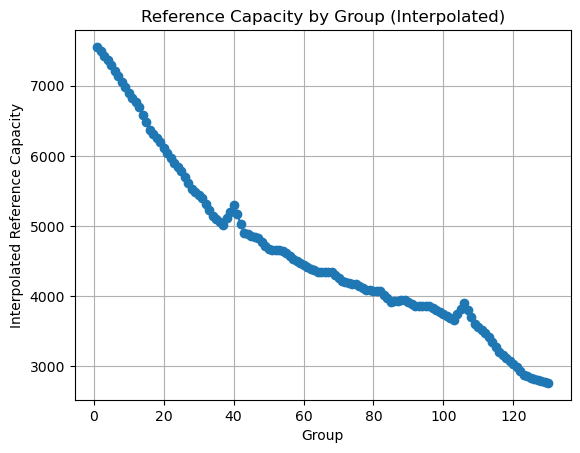

In [266]:
# ploting to make sure it looks good
# each group 1 value
df_grouped = o.groupby('group', as_index=False)['group_ref_interp'].first()

# sorting by group
df_grouped.sort_values(by='group', inplace=True)

plt.plot(df_grouped['group'], df_grouped['group_ref_interp'], marker='o', linestyle='-')
plt.xlabel('Group')
plt.ylabel('Interpolated Reference Capacity')
plt.title('Reference Capacity by Group (Interpolated)')
plt.grid(True)
plt.show()

### Clean DF

Cleaning 'o' to make sure it matches previous df schema (units, look).

In [271]:
o.head()

time  step_time  voltage  current  temperature  charge_cc  \
0   5.04       0.04    3.838   -2.007     24.38530   0.000000   
1  15.04      10.04    3.865   -2.000     24.38530  -0.005565   
2  25.04      20.04    3.878   -2.000     24.29163  -0.011121   
3  35.04      30.04    3.888   -2.000     24.24480  -0.016676   
4  45.04      40.04    3.895   -2.000     24.26041  -0.022232   

                timestamp         step_type  step            start_time  ...  \
0 2014-01-06 13:36:43.040  reference charge     0  06-Jan-2014 13:36:43  ...   
1 2014-01-06 13:36:53.040  reference charge     0  06-Jan-2014 13:36:43  ...   
2 2014-01-06 13:37:03.040  reference charge     0  06-Jan-2014 13:36:43  ...   
3 2014-01-06 13:37:13.040  reference charge     0  06-Jan-2014 13:36:43  ...   
4 2014-01-06 13:37:23.040  reference charge     0  06-Jan-2014 13:36:43  ...   

  pulsed_load pulsed_charge     rw  good_ref  group_type  group  capacity  \
0       False         False  False     False         ref      1       0.0   
1       False         False  False     False         ref      1 -0.005565   
2       False         False  False     False         ref      1 -0.011121   
3       False         False  False     False         ref      1 -0.016676   
4       False         False  False     False         ref      1 -0.022232   

  ref_capacity    group_ref group_ref_interp  
0          NaN  7551.064596      7551.064596  
1          NaN  7551.064596      7551.064596  
2          NaN  7551.064596      7551.064596  
3          NaN  7551.064596      7551.064596  
4          NaN  7551.064596      7551.064596  

[5 rows x 23 columns]

In [272]:
o.columns

Index(['time', 'step_time', 'voltage', 'current', 'temperature', 'charge_cc',
       'timestamp', 'step_type', 'step', 'start_time', 'comment', 'type',
       'ref', 'pulsed_load', 'pulsed_charge', 'rw', 'good_ref', 'group_type',
       'group', 'capacity', 'ref_capacity', 'group_ref', 'group_ref_interp'],
      dtype='object')

In [273]:
o.rename(columns={
    'capacity': 'Instantaneous Capacity',
    'group_ref_interp': 'Reference Capacity',
    'step': 'Step',
    'step_type': 'Step_Type',
    'temperature': 'Temperature',
    'current': 'Current',
    'voltage': 'Voltage',
    'step_time': 'Step Time',
    'time': 'Time'

}, inplace=True) # cleaning up spelling and capitalization

In [274]:
o.columns

Index(['Time', 'Step Time', 'Voltage', 'Current', 'Temperature', 'charge_cc',
       'timestamp', 'Step_Type', 'Step', 'start_time', 'comment', 'type',
       'ref', 'pulsed_load', 'pulsed_charge', 'rw', 'good_ref', 'group_type',
       'group', 'Instantaneous Capacity', 'ref_capacity', 'group_ref',
       'Reference Capacity'],
      dtype='object')

In [275]:
# drop not needed
o = o.drop(columns=['group', 'group_type', 'good_ref', 'rw', 'pulsed_charge', 'pulsed_load', 'ref', 'type', 'comment', 'start_time', 'timestamp', 'charge_cc', 'ref_capacity', 'group_ref'])

In [276]:
o.columns

Index(['Time', 'Step Time', 'Voltage', 'Current', 'Temperature', 'Step_Type',
       'Step', 'Instantaneous Capacity', 'Reference Capacity'],
      dtype='object')

In [277]:
o['Source'] = "NASA RW"
o['Chemistry'] = np.nan
o['Charge_Type'] = np.nan
o['Cell'] = 9 # change this for the next cell
# it mostly matches not everything is relevant to add

In [278]:
# order
o = o[['Source', 'Chemistry', 'Charge_Type', 'Cell', 'Step', 'Step_Type', 'Time', 'Voltage', 'Instantaneous Capacity', 'Temperature', 'Current', 'Step Time', 'Reference Capacity']]

In [279]:
o

Source  Chemistry  Charge_Type  Cell    Step  \
0    NASA RW        NaN          NaN     9       0   
1    NASA RW        NaN          NaN     9       0   
2    NASA RW        NaN          NaN     9       0   
3    NASA RW        NaN          NaN     9       0   
4    NASA RW        NaN          NaN     9       0   
..       ...        ...          ...   ...     ...   
716  NASA RW        NaN          NaN     9  113577   
717  NASA RW        NaN          NaN     9  113577   
718  NASA RW        NaN          NaN     9  113577   
719  NASA RW        NaN          NaN     9  113577   
720  NASA RW        NaN          NaN     9  113577   

                         Step_Type         Time  Voltage  \
0                 reference charge         5.04    3.838   
1                 reference charge        15.04    3.865   
2                 reference charge        25.04    3.878   
3                 reference charge        35.04    3.888   
4                 reference charge        45.04    3.895   
..                             ...          ...      ...   
716  rest post reference discharge  12713339.64    3.801   
717  rest post reference discharge  12713349.64    3.801   
718  rest post reference discharge  12713359.64    3.801   
719  rest post reference discharge  12713369.64    3.801   
720  rest post reference discharge  12713379.63    3.801   

    Instantaneous Capacity  Temperature  Current  Step Time  \
0                      0.0     24.38530   -2.007       0.04   
1                -0.005565     24.38530   -2.000      10.04   
2                -0.011121     24.29163   -2.000      20.04   
3                -0.016676     24.24480   -2.000      30.04   
4                -0.022232     24.26041   -2.000      40.04   
..                     ...          ...      ...        ...   
716               -0.34894     33.31358    0.000    7160.01   
717               -0.34894     33.31358    0.000    7170.01   
718               -0.34894     33.29812    0.000    7180.01   
719               -0.34894     33.29812    0.000    7190.01   
720               -0.34894     33.29812    0.000    7200.00   

     Reference Capacity  
0           7551.064596  
1           7551.064596  
2           7551.064596  
3           7551.064596  
4           7551.064596  
..                  ...  
716         2764.462952  
717         2764.462952  
718         2764.462952  
719         2764.462952  
720         2764.462952  

[8532073 rows x 13 columns]

In [280]:
o.dtypes

Source                     object
Chemistry                 float64
Charge_Type               float64
Cell                        int64
Step                        int64
Step_Type                  object
Time                      float64
Voltage                   float64
Instantaneous Capacity     object
Temperature               float64
Current                   float64
Step Time                 float64
Reference Capacity        float64
dtype: object

In [281]:
cols_to_exclude = ['Source', 'Chemistry', 'Charge_Type', 'Step_Type']

cols_to_convert = [col for col in o.columns if col not in cols_to_exclude]

# to match
o[cols_to_convert] = o[cols_to_convert].astype('float64')

In [282]:
# to match
o['Source'] = o['Source'].astype('object')
o['Chemistry'] = o['Chemistry'].astype('object')
o['Charge_Type'] = o['Charge_Type'].astype('object')
o['Step_Type'] = o['Step_Type'].astype('object')

In [283]:
o.dtypes

Source                     object
Chemistry                  object
Charge_Type                object
Cell                      float64
Step                      float64
Step_Type                  object
Time                      float64
Voltage                   float64
Instantaneous Capacity    float64
Temperature               float64
Current                   float64
Step Time                 float64
Reference Capacity        float64
dtype: object

In [284]:
o.isnull().sum() # right

Source                          0
Chemistry                 8532073
Charge_Type               8532073
Cell                            0
Step                            0
Step_Type                       0
Time                            0
Voltage                         0
Instantaneous Capacity          0
Temperature                     0
Current                         0
Step Time                       0
Reference Capacity              0
dtype: int64

In [287]:
o['Step'].is_monotonic_increasing # good and starts at 0

True

In [288]:
o['Step_Type'].unique() # now they are all in there

array(['reference charge', 'reference discharge', 'pulsed load (rest)',
       'pulsed load (discharge)', 'rest (random walk)',
       'discharge (random walk)', 'charge (random walk)',
       'pulsed charge (rest)', 'pulsed charge (charge)',
       'rest prior low current discharge',
       'low current discharge at 0.04A',
       'rest post low current discharge', 'rest post reference charge',
       'rest post reference discharge', 'rest post pulsed load or charge'],
      dtype=object)

In [88]:
o['Time'].is_monotonic_increasing 

True

In [289]:
# shift 'Time' to start at 0
o['Time'] = o['Time'] - o['Time'].min()
o['Time'].describe()

count    8.532073e+06
mean     5.853280e+06
std      3.705053e+06
min      0.000000e+00
25%      2.516448e+06
50%      5.898075e+06
75%      8.975460e+06
max      1.271337e+07
Name: Time, dtype: float64

In [290]:
o['Voltage'].describe()

count    8.532073e+06
mean     3.754602e+00
std      2.994256e-01
min      2.793000e+00
25%      3.491000e+00
50%      3.797000e+00
75%      4.021000e+00
max      4.663000e+00
Name: Voltage, dtype: float64

In [291]:
o['Instantaneous Capacity'].describe()

count    8.532073e+06
mean     1.169870e+00
std      5.386078e-01
min     -2.044560e+00
25%      1.040370e+00
50%      1.232482e+00
75%      1.462963e+00
max      2.116852e+00
Name: Instantaneous Capacity, dtype: float64

In [293]:
o['Instantaneous Capacity'] = o['Instantaneous Capacity'] * 1000
o['Instantaneous Capacity'].describe()

count    8.532073e+06
mean     1.169870e+03
std      5.386078e+02
min     -2.044560e+03
25%      1.040370e+03
50%      1.232482e+03
75%      1.462963e+03
max      2.116852e+03
Name: Instantaneous Capacity, dtype: float64

In [294]:
o['Temperature'].describe() # in C.

count    8.532073e+06
mean     3.347898e+01
std      3.755709e+00
min      1.889474e+01
25%      3.125755e+01
50%      3.370005e+01
75%      3.598795e+01
max      4.659140e+01
Name: Temperature, dtype: float64

In [295]:
o['Current'].describe() # in Amps

count    8.532073e+06
mean     2.569374e-02
std      1.818978e+00
min     -4.618000e+00
25%     -1.500000e+00
50%      0.000000e+00
75%      1.500000e+00
max      4.797000e+00
Name: Current, dtype: float64

In [94]:
# o['Step Time'] might need to be reset to zero at each new step

In [296]:
# checking this first
min_step_times = o.groupby('Step')['Step Time'].min()
print(min_step_times)

Step
0.0         0.04
1.0         0.04
2.0         0.03
3.0         0.04
4.0         0.01
            ... 
113573.0    0.01
113574.0    0.04
113575.0    0.01
113576.0    0.04
113577.0    0.01
Name: Step Time, Length: 113578, dtype: float64


In [297]:
o['Step Time'] = o.groupby('Step')['Step Time'].transform(lambda x: x - x.iloc[0])

In [299]:
o['Reference Capacity'].describe() # in mAh

count    8.532073e+06
mean     5.020507e+03
std      1.290351e+03
min      2.764463e+03
25%      3.970829e+03
50%      4.718684e+03
75%      6.039693e+03
max      7.551065e+03
Name: Reference Capacity, dtype: float64

In [300]:
o.head()

Source Chemistry Charge_Type  Cell  Step         Step_Type  Time  Voltage  \
0  NASA RW       NaN         NaN   9.0   0.0  reference charge   0.0    3.838   
1  NASA RW       NaN         NaN   9.0   0.0  reference charge  10.0    3.865   
2  NASA RW       NaN         NaN   9.0   0.0  reference charge  20.0    3.878   
3  NASA RW       NaN         NaN   9.0   0.0  reference charge  30.0    3.888   
4  NASA RW       NaN         NaN   9.0   0.0  reference charge  40.0    3.895   

   Instantaneous Capacity  Temperature  Current  Step Time  Reference Capacity  
0                0.000000     24.38530   -2.007        0.0         7551.064596  
1               -5.565278     24.38530   -2.000       10.0         7551.064596  
2              -11.120833     24.29163   -2.000       20.0         7551.064596  
3              -16.676389     24.24480   -2.000       30.0         7551.064596  
4              -22.231944     24.26041   -2.000       40.0         7551.064596

In [301]:
#o.to_parquet('C:/Users/Worm/Downloads/PartialVRFolder/RW9.parquet') # saves lol